<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="center" width="30%">

## 03_Xarray: Multiple Files

## Overview
1. Work with multiple Xarray `Dataset`s
2. Subset the Dataset along its dimensions
3. Perform unit conversions
4. Create a well-labeled multi-parameter contour plot of gridded CFSR reanalysis data

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Work with two Xarray `Dataset`s

In [2]:
year = 1993
ds_slp = xr.open_dataset(f'/cfsr/data/{year}/pmsl.1993.0p5.anl.nc')
ds_g = xr.open_dataset(f'/cfsr/data/{year}/g.1993.0p5.anl.nc')

Take a look at the sizes of these datasets.

In [3]:
print (f'Size of SLP dataset: {ds_slp.nbytes / 1e9} GB')
print (f'Size of geopotential height dataset: {ds_g.nbytes / 1e9} GB')

Size of SLP dataset: 1.517948804 GB
Size of geopotential height dataset: 48.573865732 GB


The resulting Datasets are on the order of 50 GB in size altogether, but we aren't noticing any latency thus far when accessing this Dataset. Xarray employs what's called [lazy loading](http://xarray.pydata.org/en/stable/io.html). Key point:
<blockquote>
    "Data is always loaded lazily from netCDF files. You can manipulate, slice and subset Dataset and DataArray objects, and no array values are loaded into memory until you try to perform some sort of actual computation."</blockquote>

## Subset the Datasets along their dimensions

We noticed in the previous notebook that our contour labels were not appearing with every contour line. This is because we passed the entire horizontal extent (all latitudes and longitudes) to the `ax.contour` method. Since our intent is to plot only over a regional subset, we will use the `sel` method on the latitude and longitude dimensions as well as time and isobaric surface.

We'll retrieve two data variables, geopotential and sea-level pressure, from the Dataset.

We'll also use Datetime and string methods to more dynamically assign various dimensional specifications, as well as aid in figure-labeling later on.

In [4]:
# Areal extent
lonW = -100
lonE = -60
latS = 25
latN = 55
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2

expand = 1
latRange = np.arange(latS - expand,latN + expand,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange((lonW - expand),(lonE + expand),.5) # Need to match longitude values to those of the coordinate variable

# Vertical level specificaton
plevel = 500
levelStr = str(plevel)

# Date/Time specification
Year = 1993
Month = 3
Day = 14
Hour = 12
Minute = 0
dateTime = dt(Year,Month,Day, Hour, Minute)
timeStr = dateTime.strftime("%Y-%m-%d %H%M UTC")

# Data variable selection

Z = ds_g['g'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange)
SLP = ds_slp['pmsl'].sel(time=dateTime,lat=latRange,lon=lonRange) # of course, no isobaric surface for SLP



In [5]:
levelStr

'500'

In [6]:
timeStr

'1993-03-14 1200 UTC'

Let's look at some of the attributes

In [7]:
Z.shape

(64, 84)

In [8]:
Z.dims

('lat', 'lon')

As a result of selecting just a single time and isobaric surface, both of those dimensions have been abstracted out of the DataArray.

In [9]:
Z.units

'gpm'

In [10]:
SLP.shape

(64, 84)

In [11]:
SLP.dims

('lat', 'lon')

In [12]:
SLP.units

'Pa'

#### Define our subsetted coordinate arrays of lat and lon. Pull them from either of the two DataArrays. We'll need to pass these into the contouring functions later on.

In [13]:
lats = Z.lat
lons = Z.lon

In [14]:
lats

<xarray.DataArray 'lat' (lat: 64)>
array([24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5,
       30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5,
       36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5,
       42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5,
       48. , 48.5, 49. , 49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5,
       54. , 54.5, 55. , 55.5], dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-03-14T12:00:00
  * lat      (lat) float32 24.0 24.5 25.0 25.5 26.0 ... 53.5 54.0 54.5 55.0 55.5
    lev      float32 500.0
Attributes:
    actual_range:        [-90  90]
    delta_y:             0.5
    coordinate_defines:  center
    mapping:             cylindrical_equidistant_projection_grid
    grid_resolution:     0.5_degrees
    long_name:           latitude
    units:               degrees_north

In [15]:
lons

<xarray.DataArray 'lon' (lon: 84)>
array([-101. , -100.5, -100. ,  -99.5,  -99. ,  -98.5,  -98. ,  -97.5,  -97. ,
        -96.5,  -96. ,  -95.5,  -95. ,  -94.5,  -94. ,  -93.5,  -93. ,  -92.5,
        -92. ,  -91.5,  -91. ,  -90.5,  -90. ,  -89.5,  -89. ,  -88.5,  -88. ,
        -87.5,  -87. ,  -86.5,  -86. ,  -85.5,  -85. ,  -84.5,  -84. ,  -83.5,
        -83. ,  -82.5,  -82. ,  -81.5,  -81. ,  -80.5,  -80. ,  -79.5,  -79. ,
        -78.5,  -78. ,  -77.5,  -77. ,  -76.5,  -76. ,  -75.5,  -75. ,  -74.5,
        -74. ,  -73.5,  -73. ,  -72.5,  -72. ,  -71.5,  -71. ,  -70.5,  -70. ,
        -69.5,  -69. ,  -68.5,  -68. ,  -67.5,  -67. ,  -66.5,  -66. ,  -65.5,
        -65. ,  -64.5,  -64. ,  -63.5,  -63. ,  -62.5,  -62. ,  -61.5,  -61. ,
        -60.5,  -60. ,  -59.5], dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-03-14T12:00:00
  * lon      (lon) float32 -101.0 -100.5 -100.0 -99.5 ... -60.5 -60.0 -59.5
    lev      float32 500.0
Attributes:
    actual_range:        [-180.   179.5]
    delta_x:             0.5
    coordinate_defines:  center
    mapping:             cylindrical_equidistant_projection_grid
    grid_resolution:     0.5_degrees
    long_name:           longitude
    units:               degrees_east

## Perform unit conversions

Convert geopotential meters to decameters, and Pascals to hectoPascals.

We take the DataArrays and apply [MetPy's unit conversion method](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#units).

In [16]:
SLP = SLP.metpy.convert_units('hPa')
Z = Z.metpy.convert_units('dam')

<div class="alert alert-warning">These conversions involve actual calculations, so in that cell, we are not *lazy-loading*. But that is the first instance where actual bytes of anything other than metadata get transfered ... <i>and we've already subset our original 48 GB and 2 GB Datasets into something much smaller</i>.
</div>

In [17]:
SLP.nbytes / 1e6, Z.nbytes / 1e6 # size in MB for the subsetted DataArrays

(0.021504, 0.021504)

## Create a well-labeled multi-parameter contour plot of gridded CFSR reanalysis data

We will make contour fills of 500 hPa height in decameters, with a contour interval of 6 dam, and contour lines of SLP in hPa, contour interval = 4.

As we've done before, let's first define some variables relevant to Cartopy. Recall that we already defined the areal extent up above when we did the data subsetting.

In [18]:
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

#### Now define the range of our contour values and a contour interval. 60 m is standard for 500 hPa.

In [19]:
minVal = 474
maxVal = 606
cint = 6
Zcintervals = np.arange(minVal, maxVal, cint)
Zcintervals

array([474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540, 546,
       552, 558, 564, 570, 576, 582, 588, 594, 600])

In [20]:
minVal = 900
maxVal = 1080
cint = 4
SLPcintervals = np.arange(minVal, maxVal, cint)
SLPcintervals

array([ 900,  904,  908,  912,  916,  920,  924,  928,  932,  936,  940,
        944,  948,  952,  956,  960,  964,  968,  972,  976,  980,  984,
        988,  992,  996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028,
       1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072,
       1076])

### Plot the map, with filled contours of 500 hPa geopotential heights, and contour lines of SLP.

Create a meaningful title string.

In [21]:
tl1 = f"CFSR {levelStr} hPa heights (dam, filled contours) and SLP (lines, hPa)"
tl2 = f"Valid at: {timeStr}"
title_line = (tl1 + '\n' + tl2 + '\n')

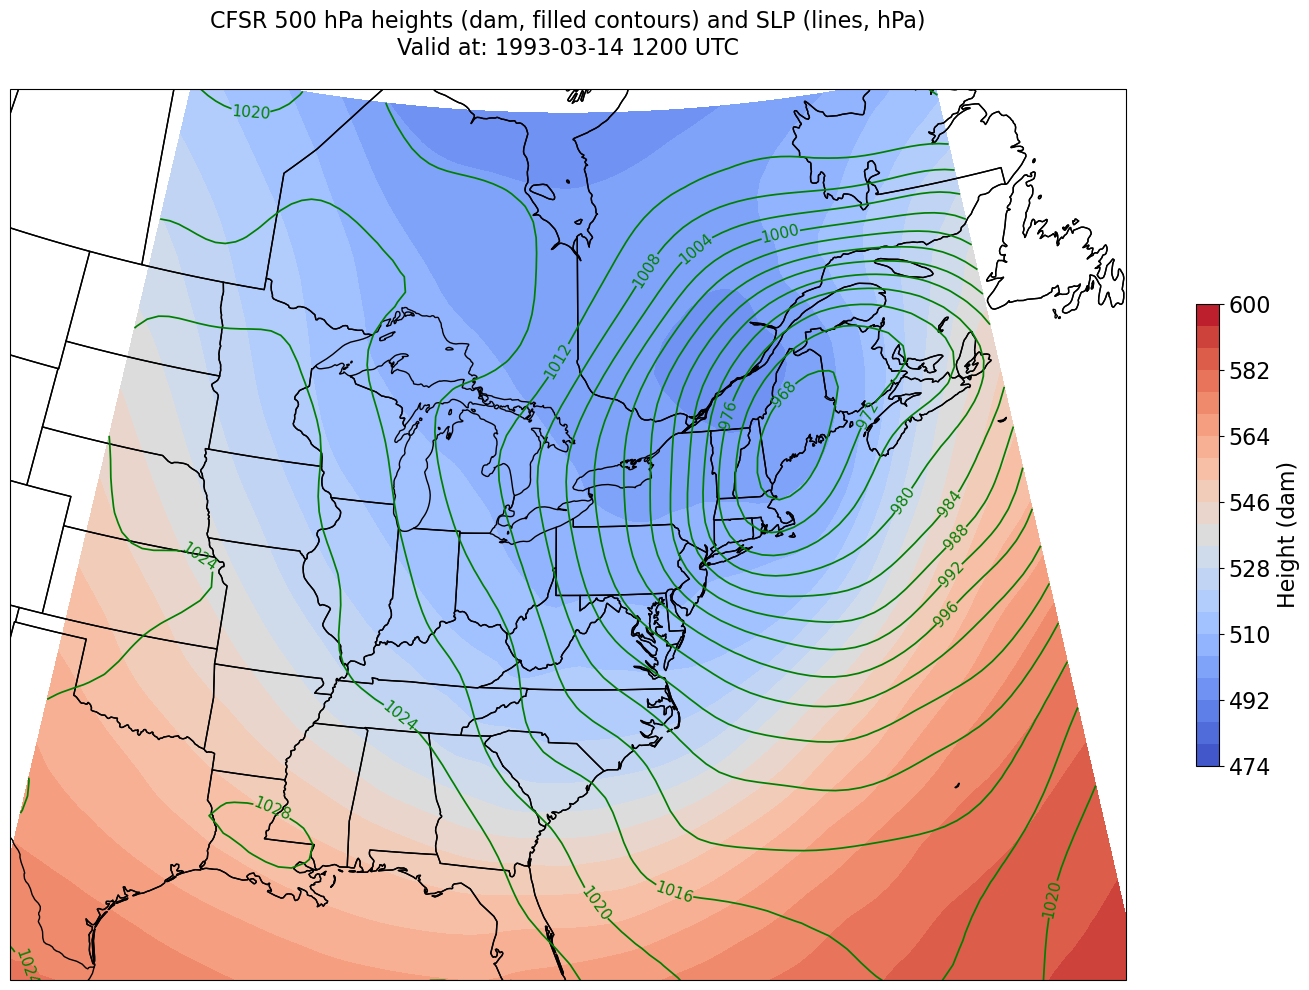

In [22]:
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree()
res = '50m'
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW,lonE,latS,latN])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
CF = ax.contourf(lons,lats,Z, levels=Zcintervals,transform=proj_data,cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Height (dam)",fontsize=16)

CL = ax.contour(lons,lats,SLP,SLPcintervals,transform=proj_data,linewidths=1.25,colors='green')
ax.clabel(CL, inline_spacing=0.2, fontsize=11, fmt='%.0f')
title = plt.title(title_line,fontsize=16)

We're just missing the outer longitudes at higher latitudes. We could do one of two things to resolve this:

1. Re-subset our original datset by extending the longitudinal range
1. Slightly constrain the map plotting region

Let's try the latter here.

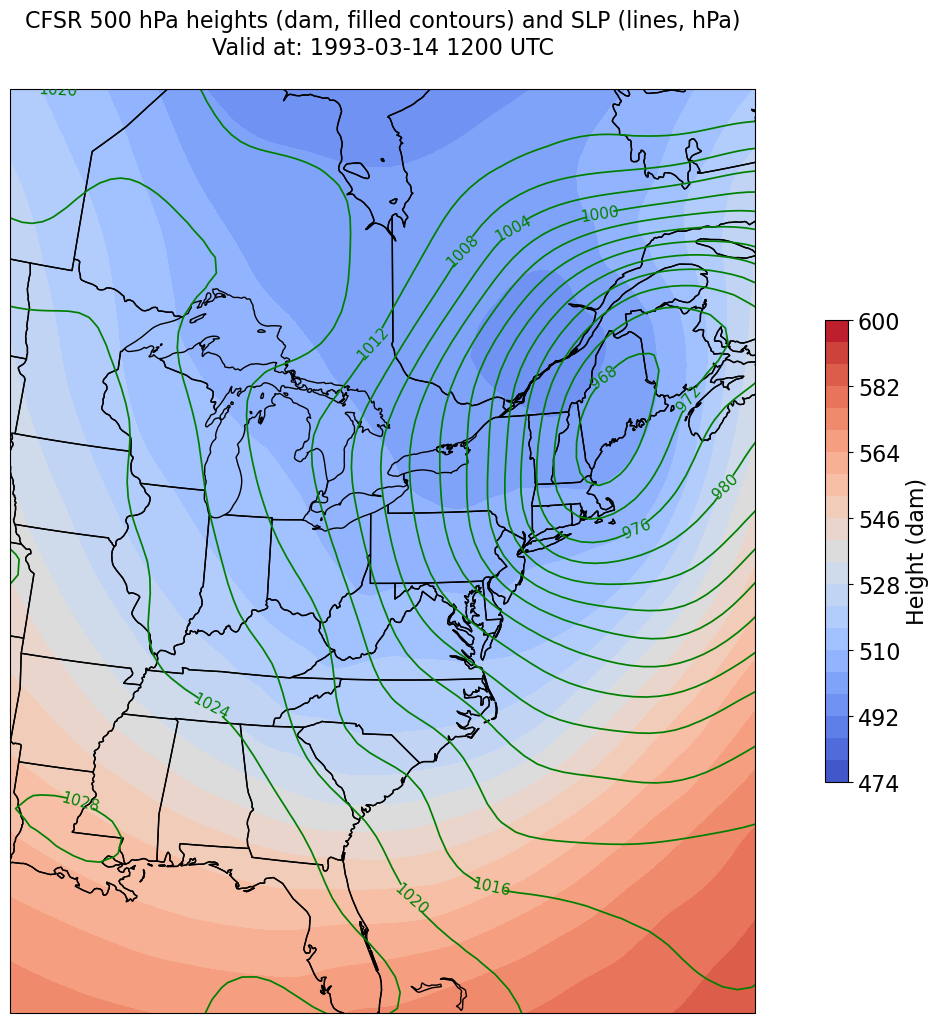

In [23]:
constrainLon = 7 # trial and error!

proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree()
res = '50m'
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS,latN])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
CF = ax.contourf(lons,lats,Z,levels=Zcintervals,transform=proj_data,cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Height (dam)",fontsize=16)

CL = ax.contour(lons,lats,SLP,SLPcintervals,transform=proj_data,linewidths=1.25,colors='green')
ax.clabel(CL, inline_spacing=0.2, fontsize=11, fmt='%.0f')
title = plt.title(title_line,fontsize=16)